<a href="https://colab.research.google.com/github/Cloud2602/gesture_recognition/blob/main/gesture_recognition_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import mediapipe as mp
import csv

# MediaPipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
)

# Percorsi
DATASET_DIR = "/content/3"  # Cambia se necessario
output_npy = "landmarks.npy"
output_labels = "labels.npy"
output_csv = "landmarks.csv"

# Output
all_landmarks = []
all_labels = []

# Mapping label
label_map = {
    "1": 1,
    "2": 2,
    "tre": 3,
    "0": 0
}

# CSV setup
csv_file = open(output_csv, mode='w', newline='')
csv_writer = csv.writer(csv_file)

# Header
header = [f'{dim}{i}' for i in range(21) for dim in ['x', 'y', 'z']]
header.append('label')
csv_writer.writerow(header)

# Contatori
total_images = 0
processed_images = 0
skipped_images = 0

# Scansiona le sottocartelle
for class_name in sorted(os.listdir(DATASET_DIR)):
    print(f"✔️ Cartella: {class_name}")
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    if class_name not in label_map:
        print(f"⚠️ La cartella '{class_name}' non ha una label definita. Saltata.")
        continue
    label = label_map[class_name]

    for filename in os.listdir(class_path):
        print(filename)
        if not filename.endswith('_Color.png'):
            continue  # ⛔ Salta file che non terminano in _Color.png

        total_images += 1

        image_path = os.path.join(class_path, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Errore nel caricamento di: {image_path}")
            skipped_images += 1
            continue

        # Converti BGR in RGB per MediaPipe
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            hand = results.multi_hand_landmarks[0]
            landmarks = []
            for lm in hand.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            all_landmarks.append(landmarks)
            all_labels.append(label)
            csv_writer.writerow(landmarks + [label])
            processed_images += 1
        else:
            print(f"🙈 Nessuna mano rilevata in: {image_path}")
            skipped_images += 1

# Cleanup
csv_file.close()
hands.close()

np.save(output_npy, np.array(all_landmarks))
np.save(output_labels, np.array(all_labels))

# Report finale
print(f"\n✅ Salvati: {output_npy}, {output_labels}, {output_csv}")
print(f"📊 Totale immagini trovate: {total_images}")
print(f"👌 Immagini elaborate con successo: {processed_images}")
print(f"🚫 Immagini scartate (errore o mano non rilevata): {skipped_images}")


In [3]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [1]:
!unzip -q "/content/dataset-hands.zip" -d "/content/dataset_hands"

### Landmark Extraction

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import csv

# Percorsi
DATASET_DIR = "/content/dataset_hands/dataset-hands/3"  # Sostituisci con il percorso corretto
output_csv = "landmarks_duemani.csv"
output_npy = "landmarks_duemani.npy"

# Setup MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# Output
all_landmarks = []
# Header aggiornato: mano destra da x0 a z20, mano sinistra da x0_L a z20_L
header = []

# Mano destra
header += [f'{dim}{i}_R' for i in range(21) for dim in ['x', 'y', 'z']]
# Mano sinistra
header += [f'{dim}{i}_L' for i in range(21) for dim in ['x', 'y', 'z']]

with open(output_csv, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(header)

    for filename in sorted(os.listdir(DATASET_DIR)):
        if not filename.endswith("_Color.png"):
            continue

        image_path = os.path.join(DATASET_DIR, filename)
        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            print(f"❌ Errore caricamento: {filename}")
            continue

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        # Landmark inizializzati a zero
        right_hand = [0.0] * (21 * 3)
        left_hand = [0.0] * (21 * 3)

        if results.multi_hand_landmarks and results.multi_handedness:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                label = handedness.classification[0].label  # "Left" o "Right"
                if label == "Right":
                  label= "Left"
                else:
                  label= "Right"
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                if label == "Right":
                    right_hand = landmarks
                else:
                    left_hand = landmarks

        # Righe composte da mano destra + mano sinistra
        combined = right_hand + left_hand
        print(f"Image-path: {image_path}")
        print(f"Landmarks: {combined}")
        all_landmarks.append(combined)
        csv_writer.writerow(combined)

# Salvataggio finale
np.save(output_npy, np.array(all_landmarks))
print(f"✅ Landmark salvati in {output_csv} e {output_npy}")


Image-path: /content/dataset_hands/dataset-hands/3/10_Color.png
Landmarks: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.43585124611854553, 0.8364418745040894, 5.61900947104732e-07, 0.40110376477241516, 0.7302819490432739, 0.04010568559169769, 0.3869937062263489, 0.6364321708679199, 0.0389338955283165, 0.37061724066734314, 0.5542641878128052, 0.03136632964015007, 0.34786486625671387, 0.5055096745491028, 0.02700674906373024, 0.43841853737831116, 0.5864442586898804, -0.02620682306587696, 0.45824259519577026, 0.4590868651866913, -0.05317099019885063, 0.4673931300640106, 0.3796965181827545, -0.06621826440095901, 0.4761573076248169, 0.32212206721305847, -0.07418942451477051, 0.4760953187942505, 0.6096633672714233, -0.048162

### Add Augumentation

In [ ]:
import os
import numpy as np

# === Funzioni di Data Augmentation ===

def flip_landmarks(landmarks):
    landmarks[:, 0] = 1.0 - landmarks[:, 0]
    return landmarks

def zoom_landmarks(landmarks, scale=0.8):
    center = landmarks[0]
    return (landmarks - center) * scale + center

def rotate_landmarks(landmarks, angle_deg=15):
    angle_rad = np.radians(angle_deg)
    center = landmarks[0]
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    rotated = np.dot(landmarks[:, :2] - center[:2], rotation_matrix) + center[:2]
    landmarks[:, :2] = rotated
    return landmarks

def translate_landmarks(landmarks, offset=(0.05, -0.03, 0.0)):
    return landmarks + np.array(offset)

# === Percorsi da modificare ===
input_base_dir = "/content/data/mediapipe_landmarks_two_hands"
output_base_dir = "/content/data_augumented"

os.makedirs(output_base_dir, exist_ok=True)

# === Elaborazione dei file ===
for folder_name in sorted(os.listdir(input_base_dir)):
    folder_path = os.path.join(input_base_dir, folder_name)
    print(f"✔️ Cartella: {folder_path}")


    for file_name in os.listdir(folder_path):
            if file_name.endswith('.npy'):
                print(f"✔️ File: {file_name}")
                file_path = os.path.join(folder_path, file_name)
                landmarks = np.load(file_path)
                augmented = []
                for i, landmark in enumerate(landmarks):

                  landmark = landmark.reshape((42, 3))  # Converti in (42, 3)
                  # Lista delle versioni aumentate

                  augmented.append(landmark.copy())

                  # Flip
                  augmented.append(flip_landmarks(landmark.copy()))

                  # Zoom out
                  augmented.append(zoom_landmarks(landmark.copy(), scale=0.8))

                  # Rotazioni
                  augmented.append(rotate_landmarks(landmark.copy(), angle_deg=15))
                  augmented.append(rotate_landmarks(landmark.copy(), angle_deg=-15))

                  # Traslazioni
                  augmented.append(translate_landmarks(landmark.copy(), offset=(0.05, -0.03, 0.0)))
                  augmented.append(translate_landmarks(landmark.copy(), offset=(-0.05, 0.03, 0.0)))
            else:
                print(f"⚠️ File non valido: {file_name}")

    print("augumented lenght: ", len(augmented))
    new_name = f"{os.path.splitext(file_name)[0]}_aug.npy"
    save_path = os.path.join(output_base_dir, new_name)
    np.save(save_path, augmented)
    print(f"✔️ File salvato: {save_path}")

In [ ]:
!git clone https://github.com/Cloud2602/gesture_recognition.git

fatal: destination path 'gesture_recognition' already exists and is not an empty directory.


In [ ]:
%cd /content/gesture_recognition
!git pull

/content/gesture_recognition
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 66 (delta 23), reused 51 (delta 12), pack-reused 0 (from 0)
Unpacking objects: 100% (66/66), 703.60 KiB | 2.67 MiB/s, done.
From https://github.com/Cloud2602/gesture_recognition
   c5ef690..c453b07  main       -> origin/main
Updating c5ef690..c453b07
Fast-forward
 .gitignore                                         |   3 +-
 .vsconfig                                          |   6 +
 Assets/.vs/slnx.sqlite                             | Bin 0 -> 90112 bytes
 Assets/Scenes/WebcamIntegration.unity              | 588 +++++++++++++++++++++
 Assets/Scenes/WebcamIntegration.unity.meta         |   7 +
 Assets/Scripts.meta                                |   8 +
 Assets/Scripts/HeartRotator.cs                     |  42 ++
 Assets/Scripts/HeartRotator.cs.meta                |  11 +
 Assets/WebcamDisplay.cs                  

In [ ]:
!pip install tensorflow

In [ ]:
%cd ..

/content


In [ ]:
!python /content/gesture_recognition/train.py

2025-05-26 20:38:04.872321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748291884.896708   10364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748291884.903775   10364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-26 20:38:09.242542: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

✅ Modello caricato!


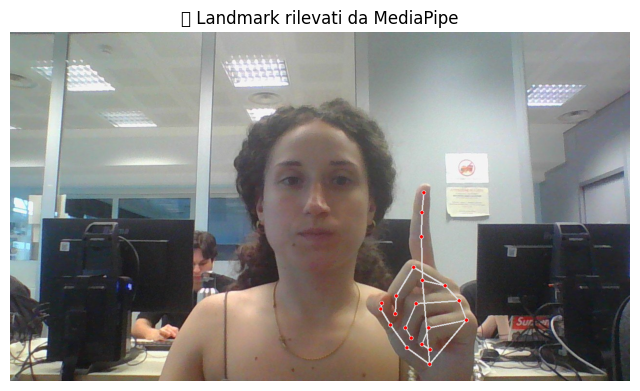

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
📈 Output del modello: [[0.06644303 0.5672761  0.17287062 0.19341026]]
🔢 Classe predetta: 1


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# === CONFIGURAZIONE ===
model_path = '/content/gesture_recognition/mlp_static_gesture_model.h5'
image_path = '/content/gesture_recognition/photo_2025-05-26_17-32-37.jpg'  # <-- Cambia con il tuo file
input_size = 126  # 21 punti x 3 coordinate x 2 mani

# === CARICA MODELLO ===
model = load_model(model_path)
print("✅ Modello caricato!")

# === SETUP MEDIAPIPE ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# === CARICA IMMAGINE ===
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError(f"❌ Immagine non trovata: {image_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === ESTRAZIONE LANDMARK ===
results = hands.process(image_rgb)

# Landmark inizializzati a zero (come nel training)
right_hand = [0.0] * (21 * 3)
left_hand = [0.0] * (21 * 3)
annotated_image = image_bgr.copy()
if results.multi_hand_landmarks and results.multi_handedness:
    for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
        mp_drawing.draw_landmarks(
              annotated_image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS
          )
        label = handedness.classification[0].label  # "Left" o "Right"
        landmarks = []
        for lm in hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
        if label == "Right":
            right_hand = landmarks
        elif label == "Left":
            left_hand = landmarks


# === MOSTRA IMMAGINE CON LANDMARK ===
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("🖐️ Landmark rilevati da MediaPipe")
plt.axis("off")
plt.show()

# === COMBINA E PREPARA INPUT ===
combined = right_hand + left_hand
input_data = np.array([combined])  # shape: (1, 126)

# === PREDIZIONE ===
prediction = model.predict(input_data)
predicted_class = np.argmax(prediction)

# === RISULTATI ===
print("📈 Output del modello:", prediction)
print("🔢 Classe predetta:", predicted_class)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, np.argmax(y_train, axis=1))
print("Test accuracy:", clf.score(X_test, np.argmax(y_test, axis=1)))
